In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"C:\Users\shez8\Desktop\fakenewslstm-main\train.csv")
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
df['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [4]:
df['text'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [6]:
# drop unnecessary columns
df = df.drop(columns=['id', 'title', 'author'], axis=1)

In [7]:
# drop null values
df = df.dropna(axis=0)

In [8]:
len(df)

20761

In [9]:
df['clean_news'] = df['text'].str.lower()
df['clean_news']

0        house dem aide: we didn’t even see comey’s let...
1        ever get the feeling your life circles the rou...
2        why the truth might get you fired october 29, ...
3        videos 15 civilians killed in single us airstr...
4        print \nan iranian woman has been sentenced to...
                               ...                        
20795    rapper t. i. unloaded on black celebrities who...
20796    when the green bay packers lost to the washing...
20797    the macy’s of today grew from the union of sev...
20798    nato, russia to hold parallel exercises in bal...
20799      david swanson is an author, activist, journa...
Name: clean_news, Length: 20761, dtype: object

In [10]:
df['clean_news'] = df['clean_news'].str.replace('[^A-Za-z0-9\s]', '')
df['clean_news'] = df['clean_news'].str.replace('\n', '')
df['clean_news'] = df['clean_news'].str.replace('\s+', ' ')
df['clean_news']

0        house dem aide: we didn’t even see comey’s let...
1        ever get the feeling your life circles the rou...
2        why the truth might get you fired october 29, ...
3        videos 15 civilians killed in single us airstr...
4        print an iranian woman has been sentenced to s...
                               ...                        
20795    rapper t. i. unloaded on black celebrities who...
20796    when the green bay packers lost to the washing...
20797    the macy’s of today grew from the union of sev...
20798    nato, russia to hold parallel exercises in bal...
20799      david swanson is an author, activist, journa...
Name: clean_news, Length: 20761, dtype: object

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shez8\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [12]:
# remove stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['clean_news'] = df['clean_news'].apply(lambda x: " ".join([word for word in x.split() if word not in stop]))
df.head()

,text,label,clean_news
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide: didn’t even see comey’s letter...
1,Ever get the feeling your life circles the rou...,0,ever get feeling life circles roundabout rathe...
2,"Why the Truth Might Get You Fired October 29, ...",1,"truth might get fired october 29, 2016 tension..."
3,Videos 15 Civilians Killed In Single US Airstr...,1,videos 15 civilians killed single us airstrike...
4,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six years prison...


In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
# tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_news'])
word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size

239490

In [15]:
# padding data
sequences = tokenizer.texts_to_sequences(df['clean_news'])
padded_seq = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

In [16]:
import urllib.request
import zipfile

# Download GloVe zip file
url = "http://nlp.stanford.edu/data/glove.6B.zip"
urllib.request.urlretrieve(url, "glove.6B.zip")

# Unzip it
with zipfile.ZipFile("glove.6B.zip", "r") as zip_ref:
    zip_ref.extractall("glove")


In [17]:
# create embedding index
embedding_index = {}
with open('./glove/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [18]:
# create embedding matrix
embedding_matrix = np.zeros((vocab_size+1, 100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [19]:
embedding_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [20]:
embedding_matrix[1]

array([ 0.13342001,  0.19998001, -0.25533   , -0.051146  ,  0.11102   ,
        0.31290999,  0.20461001, -0.16978   ,  0.23591   , -0.19870999,
        0.27361   , -0.44758999,  0.15266   ,  0.36144999,  0.042599  ,
       -0.375     ,  0.35876   ,  0.38881999, -0.71937001,  0.45868   ,
       -0.026418  , -0.28536001, -0.30691999, -0.27586001,  0.19926   ,
        0.36140999,  0.11371   , -0.34173   ,  0.44716999,  0.027599  ,
       -0.12358   ,  0.43586001, -0.043002  ,  0.019661  ,  0.0075122 ,
       -0.092998  , -0.14560001,  0.21397001,  0.043995  , -0.78390002,
       -0.082397  , -0.27105001, -0.29763001,  0.18043999, -0.18894   ,
       -0.75373   , -0.23617999,  0.019604  , -0.38022   , -0.10602   ,
       -0.031779  ,  0.37211999,  0.20428   ,  1.02499998, -0.24906   ,
       -2.09050012,  0.12701   ,  0.043019  ,  0.99423999,  0.025519  ,
       -0.12768   ,  0.68374002, -0.45173001, -0.36655   ,  1.12810004,
       -0.16283999,  0.18392999, -0.32929999,  0.73676997, -0.30

In [21]:
padded_seq[1]

array([   263,     33,   1664,     98,   5160,  29141,    455,   2398,
         2133,    400,    585,   1649,   5598,     34,     13,    851,
          195,    401,   2018,  18224,    860,  21147,   3122,   2786,
          692,    794,    274,   2102,   3296,  11415,    141,     43,
         2279,  92501,   3242,   3788,   3712,   3296,    857,    174,
         3592,     34,  10156,  58231,   3369,     20,    233,     23,
         3345,  21147,  10411,    618,     12,    526,   2537,   2552,
         8367,    512,    743,   1539,    668,    157,     16,  23475,
          955,  25154,    354,     10,    178,   3833,     60,  11860,
          931,   2822,     19,    890,   5149,    190,     53,   5616,
         2279,   4667,     46,    275,    857,    224,     15,      4,
         2267,     15,      1,   2279,  10156,     67,   8819,  11577,
       125488,  21584,   3905, 125489,  92502, 125490,   5695,  33525,
        28278,   8336,  19691,  75630,   4603,      4,    176,    278,
      

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(padded_seq, df['label'], test_size=0.20, random_state=42, stratify=df['label'])

In [23]:
from keras.layers import LSTM, Dropout, Dense, Embedding
from keras import Sequential

# model = Sequential([
#     Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
#     Dropout(0.2),
#     LSTM(128, return_sequences=True),
#     LSTM(128),
#     Dropout(0.2),
#     Dense(512),
#     Dropout(0.2),
#     Dense(256),
#     Dense(1, activation='sigmoid')
# ])

model = Sequential([
    Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(256),
    Dense(1, activation='sigmoid')
])

In [24]:
model.compile(loss=['binary_crossentropy'], optimizer='adam', metrics=['accuracy']) # Changed code: enclosed 'accuracy' in a list
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    23,949,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,949,100 (91.36 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,949,100 (91.36 MB)

In [ ]:
# train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=256, validation_data=(x_test, y_test))

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.6120 - loss: 0.6484 - val_accuracy: 0.6530 - val_loss: 0.6472
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.6660 - loss: 0.6080 - val_accuracy: 0.6453 - val_loss: 0.6199
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.6566 - loss: 0.6043 - val_accuracy: 0.6740 - val_loss: 0.6179
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.6882 - loss: 0.5741 - val_accuracy: 0.6354 - val_loss: 0.6240
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.6044 - loss: 0.6413 - val_accuracy: 0.6569 - val_loss: 0.6023
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.6426 - loss: 0.6147 - val_accuracy: 0.4996 - val_loss: 0.7192
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.5809 - loss: 0.6663 - val_accuracy: 0.6607 - val_loss: 0.5988
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.6577 - loss: 0.6004 - val_accuracy: 0.6456 - val

In [28]:
model.save("my_model.h5")

In [ ]:
# from tensorflow import keras
# model = keras.models.load_model("my_model.h5")

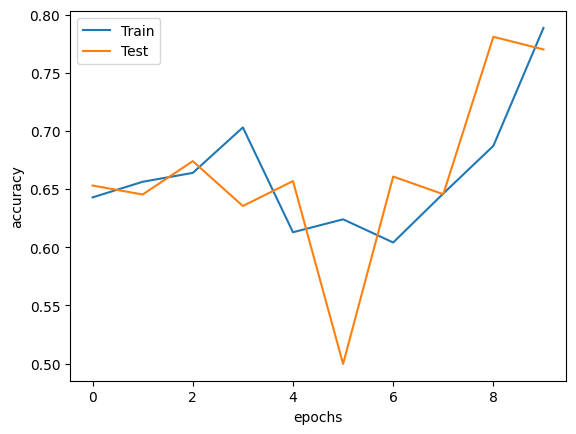

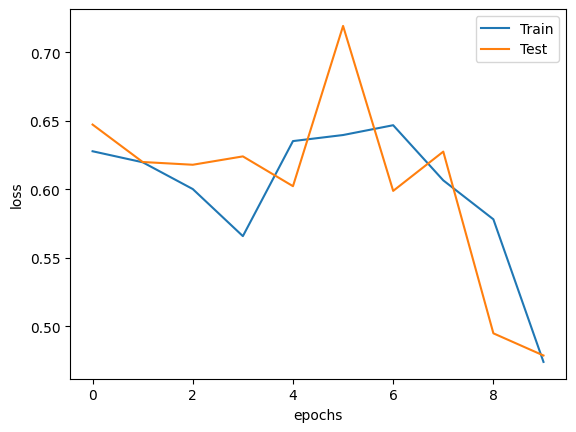

In [29]:
# visualize the results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Test'])
plt.show()